# Introduction
This notebook contains a working example to demonstrate the image perturbation and detector-based saliency map generation API.

This example will follow an application-like use case, where we define a functionally rigid process that transforms an input image into a number of saliency heatmaps based on our black-box detector's output, visualizing them over the input image.

This will necessarily include the use of a detector model to perform the role of the black-box detector for which we will be determining the saliency. We will fill this role here with a PyTorch, MSCOCO-pretrained, FasterRCNN-ResNet50 network.

### Table of Contents
* [Set Up Environment](#Set-Up-Environment)
* [The Test Image](#The-Test-Image)
* [The "Application"](#The-"Application")
* [Black-Box Detector](#Black-Box-Detector)
* [XAI Components](#XAI-Components)
* [Calling the Application](#Calling-the-Application)

### Miscellaneous

License for test image used may be found in 'COCO-LICENSE.txt'.

#### References
1. Petsiuk, Vitali, et al. "Black-box explanation of object detectors via saliency maps." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2021.

<br>

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/examples/DRISE.ipynb)

# Set Up Environment

In [1]:
!pip install -qU pip
!pip install -q xaitk-saliency
!pip install -q "torch==1.9.0"
!pip install -q "torchvision==0.10.0"

# The Test Image
We will test this application on the following image.
We know that this image contains the MS-COCO classes of "dog" and "cat".

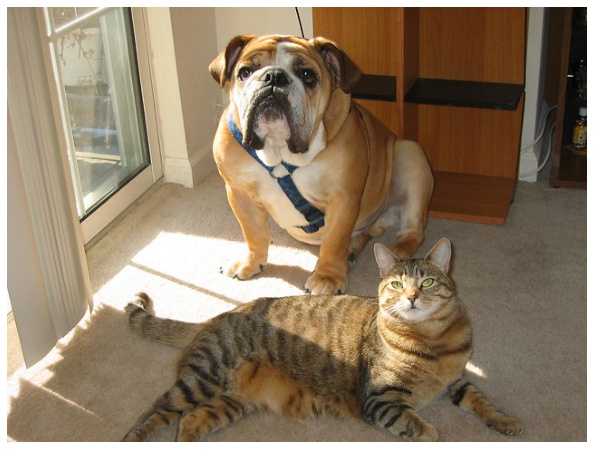

In [2]:
import PIL.Image
import matplotlib.pyplot as plt
import urllib.request


# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"


# Test image to be explained
test_image_filename = 'data/catdog.jpg'
urllib.request.urlretrieve('https://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg', test_image_filename)
plt.figure(figsize=(12, 8))
plt.axis('off')
_ = plt.imshow(PIL.Image.open(test_image_filename))

# The "Application"
First we will set up our application as a function with defined inputs for the following:
  * image
  * black-box detector
  * image perturbation API implementation
  * saliency map generation API implementation

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from typing import Callable, Optional, Sequence, Union
from xaitk_saliency import PerturbImage, GenerateDetectorProposalSaliency
from xaitk_saliency.utils.masking import occlude_image_batch
import matplotlib.patches as patches


def app(
    image_filepath: str,
    # Assuming outputs `4 + 1 + nClass` length arrays.
    blackbox_detect: Callable[[np.ndarray], np.ndarray],
    perturber: PerturbImage,
    sal_map_generator: GenerateDetectorProposalSaliency,
    fill: Optional[Union[int, Sequence[int]]] = None,
    vis_mask_examples: bool = True,
):
    # Load the image
    ref_image = np.asarray(PIL.Image.open(image_filepath))

    # Use the perterbation API implementation input to generate a bunch of images.
    # We will use the outputs here multiple times later so we will just aggregate
    # the output here.
    pert_masks = perturber(ref_image)
    print(f"Perturbation masks: {pert_masks.shape}")
    
    pert_imgs = occlude_image_batch(ref_image, pert_masks, fill)
    print(f"Perturbed images: {pert_imgs.shape[0]}")

    # Visualize some example perturbed images before heading into blackbox detection
    if vis_mask_examples:
        n = 4
        print(f"Visualizing {n} random perturbed images...")
        rng = np.random.default_rng(seed=0)
        rng_idx_lst = sorted(rng.integers(0, len(pert_masks)-1, n))
        plt.figure(figsize=(n*4, 3))
        for i, rnd_i in enumerate(rng_idx_lst):
            plt.subplot(1, n, i+1)
            plt.title(f"pert_imgs[{rnd_i}]")
            plt.axis('off')
            plt.imshow(pert_imgs[rnd_i])

    # For the saliency heatmap generation API we need reference image detections as well as
    # the detections for each of the perturbed images.
    ref_preds = blackbox_detect(ref_image, sal_class_idxs)
    print(f"Ref preds: {ref_preds.shape}")
    pert_preds = np.asarray([
        blackbox_detect(pi)
        for pi in pert_imgs
    ])

    print(f"Pert preds: {pert_preds.shape}")
    sal_maps = sal_map_generator.generate(ref_preds, pert_preds, pert_masks)
    print(f"Saliency maps: {sal_maps.shape}")

    # Visualize the saliency heat-maps
    sub_plot_ind = len(sal_maps) + 1
    plt.figure(figsize=(12, 6))
    plt.subplot(2, sub_plot_ind, 1)
    plt.imshow(ref_image)
    plt.axis('off')
    plt.title('Test Image')

    # Some magic numbers here to get colorbar to be roughly the same height
    # as the plotted image.
    colorbar_kwargs = {
        "fraction": 0.046*(ref_image.shape[0]/ref_image.shape[1]),
        "pad": 0.04,
    }

    for i, class_sal_map in enumerate(sal_maps):
        print(f"Class {i + 1} saliency map range: [{class_sal_map.min()}, {class_sal_map.max()}]")

        # Saliency
        plt.subplot(2, sub_plot_ind, 2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            class_sal_map,
            cmap='jet', alpha=0.3
        )
        ax = plt.gca()
        bbox = ref_preds[i, 0:4]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i+1} Saliency")
        plt.axis('off')

# Black-Box Detector
In this example we will use a PyTorch-based, pretrained, Faster-RCNN object detector with a ResNet50 backbone.
This model normally outputs a dictionary of predicted bounding boxes, scores, and labels. However, since our `GenerateDetectorProposalSaliency` interface also requires class probabilities, we'll hack the original implementation to output these by monkey patching the bounding box `postprocess_detections` function. We note that the [D-RISE](https://arxiv.org/abs/2006.03204) algorithm also uses these class probabilities for computing similarity between reference and perturbed detections.

In [4]:
import torch.nn.functional as F
from torchvision.ops import boxes as box_ops

def postprocess_detections(self,
                           class_logits,    # type: Tensor
                           box_regression,  # type: Tensor
                           proposals,       # type: List[Tensor]
                           image_shapes     # type: List[Tuple[int, int]]
                           ):
    # type: (...) -> Tuple[List[Tensor], List[Tensor], List[Tensor]]
    device = class_logits.device
    num_classes = class_logits.shape[-1]

    boxes_per_image = [boxes_in_image.shape[0] for boxes_in_image in proposals]
    pred_boxes = self.box_coder.decode(box_regression, proposals)

    pred_scores = F.softmax(class_logits, -1)

    pred_boxes_list = pred_boxes.split(boxes_per_image, 0)
    pred_scores_list = pred_scores.split(boxes_per_image, 0)

    all_boxes = []
    all_scores = []
    all_labels = []
    for boxes, scores, image_shape in zip(pred_boxes_list, pred_scores_list, image_shapes):
        boxes = box_ops.clip_boxes_to_image(boxes, image_shape)

        # create labels for each prediction
        labels = torch.arange(num_classes, device=device)
        labels = labels.view(1, -1).expand_as(scores)

        # remove predictions with the background label
        boxes = boxes[:, 1:]
        scores = scores[:, 1:]
        scores_orig = scores.clone()
        labels = labels[:, 1:]

        # batch everything, by making every class prediction be a separate instance
        boxes = boxes.reshape(-1, 4)
        scores = scores.reshape(-1)
        labels = labels.reshape(-1)
        
        # remove low scoring boxes
        inds = torch.where(scores > self.score_thresh)[0]
        boxes, scores, labels = boxes[inds], scores[inds], labels[inds]

        # remove empty boxes
        keep = box_ops.remove_small_boxes(boxes, min_size=1e-2)
        inds = inds[keep]
        boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

        # non-maximum suppression, independently done per class
        keep = box_ops.batched_nms(boxes, scores, labels, self.nms_thresh)
        # keep only topk scoring predictions
        keep = keep[:self.detections_per_img]
        inds = inds[keep]
        boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

        # Find corresponding row of matrix
        inds = inds // (num_classes - 1)
        
        all_boxes.append(boxes)
        all_scores.append(scores_orig[inds,:])
        all_labels.append(labels)

    return all_boxes, all_scores, all_labels

In [5]:
# Monkey patch postprocess_detections to return class probabilities instead of max class score
from torchvision.models.detection.roi_heads import RoIHeads
RoIHeads.postprocess_detections = postprocess_detections

Now we'll create our black-box detector model, asking it to explain detections corresponding to the 'dog' and 'cat' classes. For the purposes of this tool, let's say that the input blackbox detector must take in one image (as a numpy matrix) and an optional list of class indices to compute saliency for. The black-box detector then outputs a set of detections, which includes bounding boxes, objectness scores, and class probabilities (`Callable[[np.ndarray], np.ndarray]`).

The shape of this output detection matrix is `nProps x (4 + 1 + nClasses)`, where `nProps` is the number of bounding box proposals per image, the `4` and the `1` correspond to the bounding box coordinates (in [x1, y1, x2, y2] format) and objectness scores, respectively, and `nClasses` is the number of object classes (which is 80 for the MS-COCO detection dataset).

In [6]:
import os
import torch
import torchvision.models as models
from torchvision import transforms

from xaitk_saliency.utils.detection import format_detection


CUDA_AVAILABLE = torch.cuda.is_available()


# These are some simple helper functions to perform prediction with this model
model_loader = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

# Here we use box_score_thresh=0.0 to return a consistent number of proposals per image
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True,
                                                 progress=False,
                                                 box_score_thresh=0.0)
model = model.eval()
if CUDA_AVAILABLE:
    model = model.cuda()

# Class labels associated with the COCO dataset
# Source: https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection
categories = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Filter out '__background__' and N/A' classes
valid_idxs = [idx for idx, x in enumerate(categories[1:]) if x != 'N/A']


# COCO classes for which saliency maps need to be computed 
sal_classes = ['dog', 'cat']
sal_class_idxs = [categories.index(lbl) for lbl in sal_classes]


@torch.no_grad()
def blackbox_detect(test_image: np.ndarray,
                    sal_class_idxs: Optional[Union[int, Sequence[int]]] = None) -> np.ndarray:
    image_tensor = model_loader(test_image)
    if CUDA_AVAILABLE:
        image_tensor = image_tensor.cuda()
    dets = model([image_tensor])[0]

    # Get predicted boxes, class probabilities, and labels
    boxes = dets['boxes'].cpu().numpy()
    scores = dets['scores'][:, valid_idxs].cpu().numpy()
    labels = dets['labels'].cpu().numpy()
    # no "objectness" scores from this model.

    # This helper function assists in making sure the output is in the format
    # expected by the XAITK `GenerateDetectorProposalSaliency` interface.
    output = format_detection(boxes, scores)
    
    # Select detections corresponding to sal_class_idxs (if provided)
    # TODO: This fails if sal_class_idxs is an integer
    if sal_class_idxs:
        idx = [labels.tolist().index(idx) for idx in sal_class_idxs]
        output = output[idx,:]

    return output

model_mean = [0.485, 0.456, 0.406]
blackbox_fill = np.uint8(np.asarray(model_mean) * 255)

# XAI Components
Here we will set up our XAI components that comprise image perturbation and detector-based saliency map generation.

We will use the `RISEGrid` perturbation method and the `DRISEScoring` saliency map generation method.

In [7]:
from xaitk_saliency.impls.perturb_image.rise import RISEGrid
from xaitk_saliency.impls.gen_detector_prop_sal.drise_scoring import DRISEScoring

# Constructing xaitk implementations for D-RISE detector saliency map generation
rise_perturber = RISEGrid(200, 8, 0.5, seed=0, threads=4)
detect_alg = DRISEScoring()

# Calling the Application
Here we will generate DRISE-based saliency maps using our helper function defined above.

## RISE Perturbation + DRISE

Perturbation masks: (200, 480, 640)
Perturbed images: 200
Ref preds: (2, 85)


/home/brian/.cache/pypoetry/virtualenvs/xaitk-saliency-BlgCxOoJ-py3.7/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/brian/.cache/pypoetry/virtualenvs/xaitk-saliency-BlgCxOoJ-py3.7/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/n

Pert preds: (200, 100, 85)
Saliency maps: (2, 480, 640)
Class 1 saliency map range: [0.8693522490050113, 1.0]
Class 2 saliency map range: [0.856367198172182, 1.0]


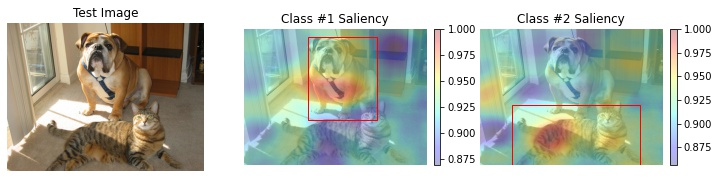

In [8]:
sal_maps = app(
    test_image_filename,
    blackbox_detect,
    rise_perturber,
    detect_alg,
    fill=blackbox_fill,
    vis_mask_examples=False,
)